# The Ocean Calls: Identifying Marine Mammal Vocalizations using Deep Learning

### by Julia Las

# Summary

Audio data collected from hydrophones deployed in different oceans since 1960 were processed to detect the presence of killer whales. The data was converted into spectrograms and classified as having a killer whale or not using deep learning. Four models were explored with ResNet50 being the best performing model. Through this project, the author was able to arrive at the following key takeaways:

1. Referring to architectures used by similar studies can greatly improve your model performance while at the same time reduce your trial and error attempts. For this study, we used the ResNet50 because it was the same architecture that was used in the humpback whale song classification study that yielded good results.
2. We cannot simply remove layers in an architecture and expect similar results. In this case, ResNet50 which has 50 layers were reduced by deleting blocks in the design. However, this resulted to poor results showing that deeper understanding of the model is needed when we attempt to redesign it.
3. When working with audio data, understanding the domain is important in order to be able to process the data correctly. Results of this project showed that the model had difficulty identifying killer whale sounds which lead to a high false negative count because of its inability to identify the sound in noise. This can be addressed by using noise reducing techniques that can make the sounds of interest more distinct. This is even more useful for smaller species of dolphins which may have even less distinct sounds than killer whales. 

## Introduction

The use of artificial intelligence in marine mammal research is a niche topic among data scientist who are equally passionate with the marine environment as they are with data science. Within the past five years, there have been promising results from multiple publications on the use of deep learning for whale call identification. This proves that the idea of using AI to analyze bioacoustics data from whales is feasible. 

However, the bulk of the publications are focused on whales while its equally popular cousin, the dolphins*, have been less successful in having their songs classified. This is potentially due to the lack of data on dolphin songs rather than the inability to apply deep learning to dolphin data. Hence, this study shall serve as a proof of concept that the methodology applied for whale song analysis can be applied for dolphins given a few modifications. 

While great success have been shown by large research institutions such as the [Monterey Bay Aquarium Research Institute (MBARI)](https://www.mbari.org/at-sea/cabled-observatory/mars-science-experiments/mars-hydrophone-data/) on the use of modern technology in research, the Philippines unfortunately still falls behind. In addition to being a proof of concept in classifying dolphin sounds, this study is also an attempt to display that Filipino data scientists can potentially collaborate with local researchers in advancing marine research in the country. 

**In case you are wondering, killer whales, despite its name, is part of the family Delphinidae. A lot of dolphins are wrongly named as whales such as pilot whales and melon-headed whales.* 

## Data Description

The data used in this project was taken from [Orcadata Wiki](https://github.com/orcasound/orcadata/wiki). Orcadata Wiki is a Github site of the Orcasound project - both of which are made to foster collaboration and volunteerism among marine mammal enthusiasts to advance marine mammal research. In addition, Orcadata wiki is regularly updated with progress on machine learning resources related to orcas. 

Multiple data can be obtained from Orcadata Wiki. For this project, the [Pod.Cast](https://github.com/orcasound/orcadata/wiki/Pod.Cast-data-archive) was chosen which contains labeled raw WAV format split into training and test data. Data processing guides were also included which were heavily used in this analysis. 

## Methodology

The following steps were followed in order to arrive at results:
1. Inspect the `annotations.tsv` file provided to get an overview of the data.
2. Preprocess the data by converting the files into windows and splitting them into train and validation sets.
3. Classify the windows using different deep learning architectures.
4. Evaluate the results. 

In [1]:
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from pathlib import Path
from tqdm import tqdm
import pickle
import sys

sys.path.append('..')
import src.params as params
import src.dataloader as dataloader

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f5jq5dq5 because the default path (/home/jlas/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## 1. Inspect and explore the data

We will first read the tsv file provided to get an idea on how the data looks like. Here, we can see that there are multiple datasets going from as far back as 1960 all the way to 2020 containing WAV files. A single WAV file is separated into multiple rows with different start time and duration. 

In [2]:
# Read the tsv file
tsv_files = pd.read_csv('../../TrainDataLatest/annotations.tsv', sep='\t')
print(tsv_files.shape)
tsv_files.head()

(5537, 7)


,dataset,wav_filename,start_time_s,duration_s,location,date,pst_or_master_tape_identifier
0,podcast_round1,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",1960-10-28,60012
1,podcast_round1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",1960-10-28,60012
2,podcast_round1,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",1960-10-28,60012
3,podcast_round1,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",1960-10-28,60012
4,podcast_round1,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",1960-10-28,60012


In [3]:
# Check the date of the file
tsv_files['date'].unique()

array(['1960-10-28', '1993-06-01', '1997-01-01', '1998-01-13',
       '1998-03-26', '1998-04-13', '1960-12-21', '1958-02-19',
       '1964-08-16', '1964-08-17', '1964-08-18', '1964-07-17',
       '1966-05-13', '1976-08-04', '1989-09-09', '1992-12-30',
       '1992-12-29', '1993-04-01', '1997-02-12', '1997-02-14',
       '1997-02-13', '1997-02-16', '1997-02-18', '1997-02-21',
       '1997-05-22', '1997-06-10', '1997-04-28', '1997-09-09',
       '1998-01-08', '1998-01-09', '1998-01-12', '1998-01-14',
       '1998-01-15', '1998-01-16', '1998-01-06', '1998-01-17',
       '1998-01-18', '1998-01-19', '1998-01-20', '1998-04-16',
       '1998-04-12', '1998-04-11', '1998-03-27', '1998-03-11',
       '1998-03-08', '1998-03-03', '1998-02-28', '1998-02-22',
       '1998-02-21', '1998-02-20', '1998-02-19', '1998-02-17',
       '1998-01-31', '1998-01-30', '1998-01-29', '1998-10-10',
       '19610-08-01', '19640-08-01', '19650-08-01', '19660-08-01',
       '19670-08-01', '19780-08-01', '19790-08-01',

We can observe from the list below that a dataset can come from multiple locations and a location can be split into multiple dataset with `podcast_round1` having the most data.

In [4]:
# Check the number of files per dataset and location
tsv_files.groupby(['dataset', 'location'])['wav_filename'].nunique()

dataset          location                                                           
podcast_round1   80 mi. south of Martha's Vineyard, Massachusetts                          1
                 80 mi. south of Martha's Vineyard, Massachusetts    X                     1
                 Andenes, Norway                                                         156
                 Dabob Bay, Seattle, Washington                                            1
                 Kikvika, Norway                                                         472
                 Oregon Coast Aquarium                                                  1011
                 Oregon Coastal Aquarium, Newport, OR                                    437
                 Oregon Coastal Aquarium, Newport, OR    X                                 5
                 Outside St. John's Hbr., Newfoundland                                    13
                 Saanich Inlet, Victoria, VAncouver Island, British Columbia, 

We are unable to process some of the files so we will only be using a subset moving forward but this subset still contains majority of the data.

In [5]:
# Obtain a subset to be used for the analysis
subset = ['podcast_round1', 'podcast_round2',
          'podcast_round3', 'podcast_round5', 'podcast_round11']
df = tsv_files[tsv_files['dataset'].isin(subset)]
df['dataset'].unique()

array(['podcast_round1', 'podcast_round2', 'podcast_round3',
       'podcast_round5', 'podcast_round11'], dtype=object)

In [6]:
# Check the number of files to be used
print(f"Total number of files: {tsv_files['wav_filename'].nunique()}")
print(f"Number of files to be used: {df['wav_filename'].nunique()}")
print(f"Number of files dropped: {tsv_files['wav_filename'].nunique() - df['wav_filename'].nunique()}")
print(f"Number of unique WAV files: {df['pst_or_master_tape_identifier'].nunique()}")

Total number of files: 2863
Number of files to be used: 2474
Number of files dropped: 389
Number of unique WAV files: 254


## 2. Preprocess and split the data

From the total number of unique WAV files, we arbitrarily obtained 12% (30 files) for our validation set. The remaining files were assigned to the training data. Using `dataloader.AudioFileDataset`, we were able to split these files into windows using the start time and duration in the `annotations.tsv` file. We then saved this as a pickle file for faster access in succeeding runs. 

In [7]:
# Randomly choose files to include in validation set
dev_master_wavs = ["60012", "92303", "97745", '97782', '97768', '97783',
                   '64017', '64019', '66016', '97751', '97752', '97754',
                   '08:19:00', '08:25:00', '10:28:00', '10:55:00', '10:28:00',
                   '10:55:00', '09:45:00', '09:50:00', '09:56:00', '19:18:00',
                   '19:36:00', '12:12:00', '15:24:00', '15:28:00', '02:00:00',
                   '12:39:00', '19:47:00', '11:53:00']

print(len(dev_master_wavs))

30


In [8]:
# Assign these files to training or to validation
train_df = (df[~df.pst_or_master_tape_identifier.isin(dev_master_wavs)]
            .sort_values(['wav_filename', 'start_time_s'])
            .reset_index(drop=True))
dev_df = (df[tsv_files.pst_or_master_tape_identifier.isin(dev_master_wavs)]
          .sort_values(['wav_filename', 'start_time_s'])
          .reset_index(drop=True))

/tmp/ipykernel_21148/1451428480.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dev_df = (df[tsv_files.pst_or_master_tape_identifier.isin(dev_master_wavs)]


In [9]:
# Save the selected files to a tsv file
# train_df.to_csv("../../TrainDataLatest/train.tsv", sep='\t',index=False)
# dev_df.to_csv("../../TrainDataLatest/dev.tsv", sep='\t',index=False)

In [93]:
# Load and check the new train file
train = pd.read_csv("../../TrainDataLatest/train.tsv",sep='\t')
train.head()

,dataset,wav_filename,start_time_s,duration_s,location,date,pst_or_master_tape_identifier
0,podcast_round2,1562337136_0004.wav,37.345486,1.743924,orcasound_lab,2019-07-05,07:32:16
1,podcast_round2,1562337136_0004.wav,41.046007,1.658854,orcasound_lab,2019-07-05,07:32:16
2,podcast_round2,1562337136_0004.wav,42.917535,2.594618,orcasound_lab,2019-07-05,07:32:16
3,podcast_round2,1562337136_0004.wav,45.980035,2.041667,orcasound_lab,2019-07-05,07:32:16
4,podcast_round2,1562337136_0004.wav,49.765625,2.450000,orcasound_lab,2019-07-05,07:32:16


dataset                           podcast_round1
wav_filename                        9230201V.wav
start_time_s                                 0.0
duration_s                                 3.295
location                         Kikvika, Norway
date                                  1992-12-29
pst_or_master_tape_identifier              92302
Name: 1800, dtype: object


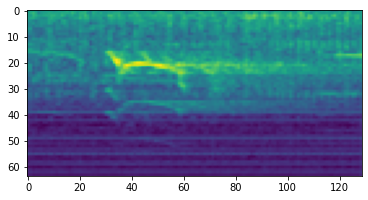

In [97]:
# inspect a few random annotations 
row = train.iloc[np.random.randint(len(train))]
print(row)

af = dataloader.AudioFile(f"../../TrainDataLatest/wav/{row['wav_filename']}",
                          params.SAMPLE_RATE)
start_idx = int(row["start_time_s"] * params.SAMPLE_RATE) 
end_idx = int(start_idx + row["duration_s"] * params.SAMPLE_RATE)

plt.imshow(af.get_window(start_idx, end_idx).T);

In [11]:
# Create the data
# wav_dataset = dataloader.AudioFileDataset(
#     "../../TrainDataLatest/wav", 
#     "../../TrainDataLatest/train.tsv",
#     mean="../../TrainDataLatest/mean.tsv",
#     invstd="../../TrainDataLatest/invst.tsv")

# wav_dataset_dev = dataloader.AudioFileDataset(
#     "../../TrainDataLatest/wav", 
#     "../../TrainDataLatest/dev.tsv",
#     mean="../../TrainDataLatest/dev_mean.tsv",
#     invstd="../../TrainDataLatest/dev_invst.tsv")

# test_dataset = dataloader.AudioFileDataset(
#     "../../TestDataLatest_PodCastAllRounds_123/wav", 
#     "../../TestDataLatest_PodCastAllRounds_123/test.tsv",
#     mean="../../TestDataLatest_PodCastAllRounds_123/mean.tsv",
#     invstd="../../TestDataLatest_PodCastAllRounds_123/invst.tsv")

In [12]:
# Save the data into pickle file
# with open('wav_dataset.pkl', 'wb') as f:
#     pickle.dump(wav_dataset, f)
    
# with open('wav_dataset_dev.pkl', 'wb') as f:
#     pickle.dump(wav_dataset_dev, f)
    
# with open('test_dataset.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f)

We now have a dataset containing windows for each sound file. We can see in the cell below the number of entries for train, val, and test. These were obtained from the 2474 files in the subset.

In [13]:
# Load the data from the pickle file
with open('wav_dataset.pkl', 'rb') as f:
    wav_dataset = pickle.load(f)
    
with open('wav_dataset_dev.pkl', 'rb') as f:
    wav_dataset_dev = pickle.load(f)
    
with open('test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)
    
# Check size of data
print(f"Files in train set:      {len(wav_dataset)}")
print(f"Files in validation set: {len(wav_dataset_dev)}")
print(f"Files in test set:       {len(test_dataset)}")

Files in train set:      14130
Files in validation set: 1192
Files in test set:       3457


In the bar charts below, we can see that the data is imbalanced. Only around 30% of the data has killer whale sounds. We therefore need to address this imbalance when we model.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test % whale: 23.86')

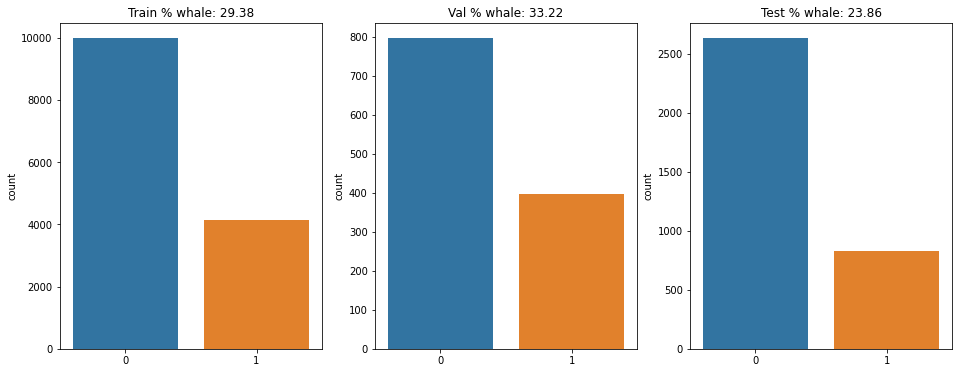

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs.ravel()

train_labels = [l[2] for l in wav_dataset.windows]
val_labels = [l[2] for l in wav_dataset_dev.windows]
test_labels = [l[2] for l in test_dataset.windows]

train_label_pct = sum(train_labels)/len(train_labels)*100
val_label_pct = sum(val_labels)/len(val_labels)*100
test_label_pct = sum(test_labels)/len(test_labels)*100

sns.countplot(train_labels, ax=ax[0])
ax[0].set_title(f"Train % whale: {train_label_pct:.2f}")
sns.countplot(val_labels, ax=ax[1])
ax[1].set_title(f"Val % whale: {val_label_pct:.2f}")
sns.countplot(test_labels, ax=ax[2])
ax[2].set_title(f"Test % whale: {test_label_pct:.2f}")

In [15]:
# Inspect the window data
print(len(wav_dataset.windows))
print(f'\nWindow')
display(wav_dataset.windows[:20])

14130

Window


[(0, 49000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (49000, 98000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (98000, 147000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (147000, 196000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (196000, 245000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (245000, 294000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (294000, 343000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (343000, 392000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (392000, 441000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (441000, 490000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (490000, 539000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (539000, 588000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (588000, 637000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (637000, 686000, 0, <src.dataloader.AudioFile at 0x7f1bed1f5520>),
 (686000, 735000, 0, <src.dataloader.AudioFile at 0x7f1be

We can obtain some intuition by checking how a spectrogram with killer whale sounds looks like. We can filter all the windows with killer whales from the list of windows and randomly visualize a few from those. The same process can be applied to non-killer whales spectrograms. We again save these spectrograms to a pickle file which will be used for modeling.

In [16]:
# Identify the windows with killer whale and without killer whale
whale = [n for n, l in enumerate(wav_dataset.windows) if l[2] == 1]
non_whale = [n for n, l in enumerate(wav_dataset.windows) if l[2] == 0]

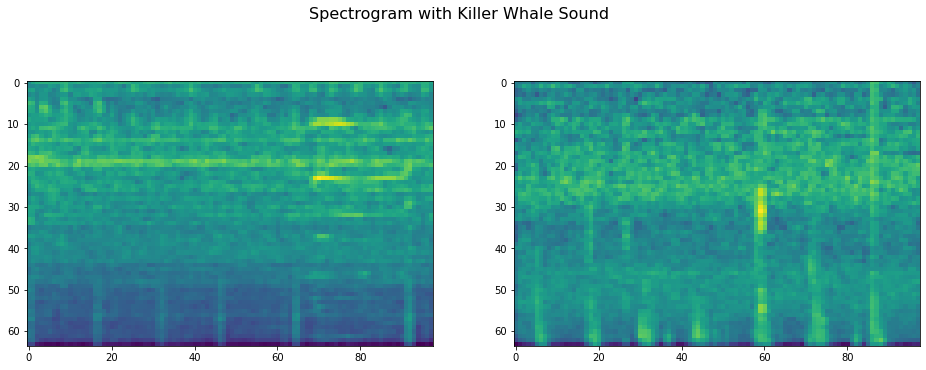

In [122]:
# Plot the windows with killer whale
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs.ravel()

af1 = wav_dataset.windows[9190][3]
af2 = wav_dataset.windows[590][3]
start_idx = int(0 * params.SAMPLE_RATE) 
end_idx = int(2.5 * params.SAMPLE_RATE)

ax[0].imshow(af1.get_window(start_idx, end_idx).T);
ax[1].imshow(af2.get_window(start_idx, end_idx).T)
plt.suptitle("Spectrogram with Killer Whale Sound", fontsize=16);


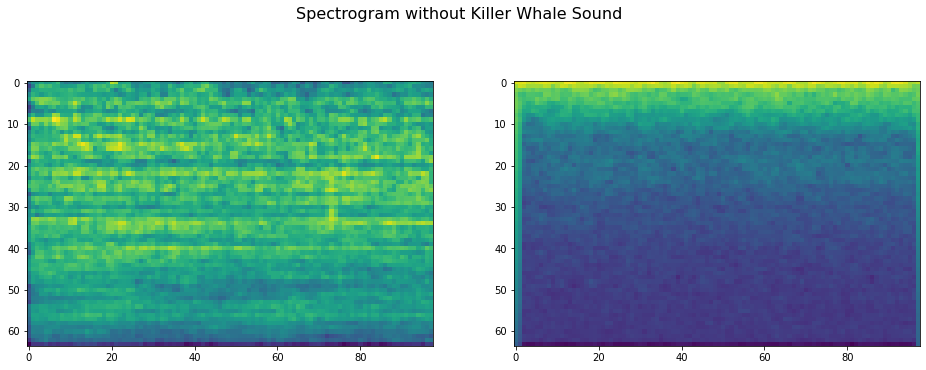

In [123]:
# Plot the windows without killer whale
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs.ravel()

af1 = wav_dataset.windows[13697][3]
af2 = wav_dataset.windows[1696][3]
start_idx = int(0 * params.SAMPLE_RATE) 
end_idx = int(2.5 * params.SAMPLE_RATE)

ax[0].imshow(af1.get_window(start_idx, end_idx).T);
ax[1].imshow(af2.get_window(start_idx, end_idx).T)
plt.suptitle("Spectrogram without Killer Whale Sound", fontsize=16);

In [19]:
# train_image = []
# train_label = []
# for i in tqdm(range(len(wav_dataset.windows))):
#     x = wav_dataset.windows[i][3]
#     y = x.get_window(wav_dataset.windows[i][0], wav_dataset.windows[i][1]).T
#     train_image.append(y)
#     train_label.append(wav_dataset.windows[i][2])

In [20]:
# val_image = []
# val_label = []
# for i in tqdm(range(len(wav_dataset_dev.windows))):
#     x = wav_dataset_dev.windows[i][3]
#     y = x.get_window(wav_dataset_dev.windows[i][0],
#                      wav_dataset_dev.windows[i][1]).T
#     val_image.append(y)
#     val_label.append(wav_dataset_dev.windows[i][2])

In [21]:
# test_image = []
# test_label = []
# for i in tqdm(range(len(test_dataset.windows))):
#     x = test_dataset.windows[i][3]
#     y = x.get_window(test_dataset.windows[i][0],
#                      test_dataset.windows[i][1]).T
#     test_image.append(y)
#     test_label.append(test_dataset.windows[i][2])

In [22]:
# with open('train_data.pkl', 'wb') as f:
#     pickle.dump(train_image, f)
    
# with open('train_label.pkl', 'wb') as f:
#     pickle.dump(train_label, f)
    
# with open('val_data.pkl', 'wb') as f:
#     pickle.dump(val_image, f)
    
# with open('val_label.pkl', 'wb') as f:
#     pickle.dump(val_label, f)
    
# with open('test_image.pkl', 'wb') as f:
#     pickle.dump(test_image, f)
    
# with open('test_label.pkl', 'wb') as f:
#     pickle.dump(test_label, f)

## 3. Modeling

Four models were tested to classify the spectrograms. The first model is a basic convolutional neural network with max pooling. This was used to serve as the baseline model to show how a simple model will perform. This was followed by the same model but using focal loss as the loss function. As seen in the EDA above, the data is imbalanced. Focal loss was used to see if it performs better in predicting the minority class, which in this case is the killer whale.

Next we tried copying the ResNet50 architecture. ResNet50 was the architecture used in the published humpback whale classification paper. Since we are working with audio data originally, we could not directly use the pre-trained ResNet50 model. Instead, we copied the architecture using the guide from [machinelearningknowledge.ai](https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/) and attempted to obtain good results. 

Another hypothesis is that the ResNet50 may be too much for our need. We attempted to remove a few layers of the ResNet50 architecture to create a customized ResNet and see how this performs in comparison with the former.

In [23]:
# Load the images
with open('train_data.pkl', 'rb') as f:
    train_image = pickle.load(f)
    
with open('train_label.pkl', 'rb') as f:
    train_label = pickle.load(f)
    
with open('val_data.pkl', 'rb') as f:
    val_image = pickle.load(f)
    
with open('val_label.pkl', 'rb') as f:
    val_label = pickle.load(f)
    
with open('test_image.pkl', 'rb') as f:
    test_image = pickle.load(f)
    
with open('test_label.pkl', 'rb') as f:
    test_label = pickle.load(f)

In [24]:
# Convert images to float
train_image = np.array(train_image).astype("float32")
val_image = np.array(val_image).astype("float32")
test_image = np.array(test_image).astype("float32")

### a. Simple CNN

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(64, 96, 1))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

2022-03-16 04:07:03.357697: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 04:07:07.437597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8706 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 96, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 20, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0     

In [28]:
import tensorflow as tf
model.compile(optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.Precision()])

model.fit(train_image, np.array(train_label),
          epochs=10, batch_size=64,
          validation_data=(val_image, np.array(val_label)))

2022-03-16 04:07:08.425547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-16 04:07:09.896203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-03-16 04:07:10.598074: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-16 04:07:10.599213: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-16 04:07:10.599243: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-16 04:07:10.600138: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-16 04:07:10.600210: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


221/221 [==============================] - 7s 16ms/step - loss: 0.5878 - precision: 0.6408 - val_loss: 0.5248 - val_precision: 0.7876
Epoch 2/10
221/221 [==============================] - 3s 12ms/step - loss: 0.3882 - precision: 0.8036 - val_loss: 0.4420 - val_precision: 0.7855
Epoch 3/10
221/221 [==============================] - 3s 12ms/step - loss: 0.3173 - precision: 0.8753 - val_loss: 0.4662 - val_precision: 0.9404
Epoch 4/10
221/221 [==============================] - 3s 12ms/step - loss: 0.2878 - precision: 0.8962 - val_loss: 0.4043 - val_precision: 0.9196
Epoch 5/10
221/221 [==============================] - 3s 12ms/step - loss: 0.2645 - precision: 0.9036 - val_loss: 0.5308 - val_precision: 0.9910
Epoch 6/10
221/221 [==============================] - 3s 13ms/step - loss: 0.2474 - precision: 0.9127 - val_loss: 0.4015 - val_precision: 0.9429
Epoch 7/10
221/221 [==============================] - 3s 13ms/step - loss: 0.2347 - precision: 0.9162 - val_loss: 0.3861 - val_precision: 0.8

In [29]:
test_loss, test_acc = model.evaluate(test_image, np.array(test_label))

109/109 [==============================] - 1s 8ms/step - loss: 0.3716 - precision: 0.7222


In [30]:
print(test_acc)
print(test_loss)

0.7222222089767456
0.37162381410598755


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test_image)
y_pred = (pred > 0.5)
print(classification_report(np.array(test_label), y_pred))
print(confusion_matrix(np.array(test_label), y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2632
           1       0.72      0.65      0.68       825

    accuracy                           0.86      3457
   macro avg       0.81      0.78      0.79      3457
weighted avg       0.85      0.86      0.85      3457

[[2427  205]
 [ 292  533]]


### b. CNN using focal loss

In [32]:
import tensorflow_addons as tfa

def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):
        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
        y_true_K = tf.ones_like(y_true)
        focal_loss = fl(y_true, y_pred)
        return focal_loss
    return binary_focal_loss

In [33]:
model_focal_loss = model
model_focal_loss.compile(optimizer="rmsprop",
    loss=focal_loss_custom(alpha=0.2, gamma=2.0),
    metrics=[tf.keras.metrics.Precision()])

model_focal_loss.fit(train_image, np.array(train_label),
          epochs=10, batch_size=64,
          validation_data=(val_image, np.array(val_label)))

Epoch 1/10
221/221 [==============================] - 4s 14ms/step - loss: 0.0190 - precision_1: 0.9685 - val_loss: 0.0388 - val_precision_1: 0.9278
Epoch 2/10
221/221 [==============================] - 3s 13ms/step - loss: 0.0168 - precision_1: 0.9735 - val_loss: 0.0365 - val_precision_1: 0.9701
Epoch 3/10
221/221 [==============================] - 3s 13ms/step - loss: 0.0153 - precision_1: 0.9773 - val_loss: 0.0372 - val_precision_1: 0.9711
Epoch 4/10
221/221 [==============================] - 3s 13ms/step - loss: 0.0137 - precision_1: 0.9777 - val_loss: 0.0351 - val_precision_1: 0.9602
Epoch 5/10
221/221 [==============================] - 3s 13ms/step - loss: 0.0127 - precision_1: 0.9824 - val_loss: 0.0437 - val_precision_1: 0.9065
Epoch 6/10
221/221 [==============================] - 3s 13ms/step - loss: 0.0117 - precision_1: 0.9837 - val_loss: 0.0484 - val_precision_1: 0.8866
Epoch 7/10
221/221 [==============================] - 3s 13ms/step - loss: 0.0148 - precision_1: 0.9745 - 

In [34]:
test_loss, test_acc = model_focal_loss.evaluate(test_image, np.array(test_label))

109/109 [==============================] - 1s 6ms/step - loss: 0.1016 - precision_1: 0.6551


In [35]:
print(test_acc)
print(test_loss)

0.655089795589447
0.10155697911977768


In [36]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model_focal_loss.predict(test_image)
y_pred = (pred > 0.5)
print(classification_report(np.array(test_label), y_pred))
print(confusion_matrix(np.array(test_label), y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2632
           1       0.66      0.66      0.66       825

    accuracy                           0.84      3457
   macro avg       0.77      0.78      0.78      3457
weighted avg       0.84      0.84      0.84      3457

[[2344  288]
 [ 278  547]]


### c. ResNet50


In [37]:
from keras import backend as K
import keras
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D,
                          BatchNormalization, Flatten, Conv2D,
                          AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,
                          MaxPool2D)
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [38]:
## https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid',
               name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s),
                        padding='valid', name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [39]:
base_model = ResNet50(input_shape=(64, 96, 1))

In [40]:
headModel_res50 = base_model.output
headModel_res50 = Flatten()(headModel_res50)
headModel_res50 = Dense(256, activation='relu', name='fc1',
                  kernel_initializer=glorot_uniform(seed=0))(headModel_res50)
headModel_res50 = Dense(128, activation='relu', name='fc2',
                  kernel_initializer=glorot_uniform(seed=0))(headModel_res50)
headModel_res50 = Dense(1,activation='sigmoid', name='fc3',
                  kernel_initializer=glorot_uniform(seed=0))(headModel_res50)

In [41]:
model_resnet50 = Model(inputs=base_model.input, outputs=headModel_res50)
model_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 102, 1)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [42]:
# real resnet
import tensorflow as tf
model_resnet50.compile(optimizer="rmsprop",
    loss=focal_loss_custom(alpha=0.2, gamma=2.0),
    #loss="binary_crossentropy",
    metrics=[tf.keras.metrics.Precision()])

res50_history = model_resnet50.fit(train_image, np.array(train_label),
          epochs=10, batch_size=64,
          validation_data=(val_image, np.array(val_label)))

Epoch 1/10
221/221 [==============================] - 34s 99ms/step - loss: 0.0984 - precision_2: 0.6787 - val_loss: 8.1154 - val_precision_2: 0.3322
Epoch 2/10
221/221 [==============================] - 18s 81ms/step - loss: 0.0631 - precision_2: 0.8527 - val_loss: 0.0608 - val_precision_2: 0.8852
Epoch 3/10
221/221 [==============================] - 18s 81ms/step - loss: 0.0425 - precision_2: 0.9184 - val_loss: 0.7531 - val_precision_2: 0.3436
Epoch 4/10
221/221 [==============================] - 18s 81ms/step - loss: 0.0347 - precision_2: 0.9598 - val_loss: 0.3940 - val_precision_2: 0.3995
Epoch 5/10
221/221 [==============================] - 18s 81ms/step - loss: 0.0285 - precision_2: 0.9614 - val_loss: 1.6962 - val_precision_2: 0.3469
Epoch 6/10
221/221 [==============================] - 18s 80ms/step - loss: 0.0263 - precision_2: 0.9702 - val_loss: 0.0361 - val_precision_2: 0.9798
Epoch 7/10
221/221 [==============================] - 18s 81ms/step - loss: 0.0242 - precision_2: 0.

In [43]:
# real resnet
test_loss, test_acc = model_resnet50.evaluate(test_image, np.array(test_label))
print(test_acc)
print(test_loss)

from sklearn.metrics import confusion_matrix, classification_report

pred = model_resnet50.predict(test_image)
y_pred = (pred > 0.5)
print(classification_report(np.array(test_label), y_pred))
print(confusion_matrix(np.array(test_label), y_pred))

109/109 [==============================] - 5s 35ms/step - loss: 0.0306 - precision_2: 0.9967
0.9967105388641357
0.030573993921279907
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2632
           1       1.00      0.37      0.54       825

    accuracy                           0.85      3457
   macro avg       0.92      0.68      0.72      3457
weighted avg       0.87      0.85      0.82      3457

[[2631    1]
 [ 522  303]]


In [44]:
from keras.models import load_model
model_resnet50.save('model_resnet50.h5')

/home/msds2022/jlas/.local/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### d. ResNet modified

In [45]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid',
               name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s),
                        padding='valid', name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50_mod(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [46]:
base_model = ResNet50_mod(input_shape=(64, 96, 1))

In [47]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(256, activation='relu', name='fc1',
                  kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(128, activation='relu', name='fc2',
                  kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(1,activation='sigmoid', name='fc3',
                  kernel_initializer=glorot_uniform(seed=0))(headModel)

In [48]:
model_resnet_cust = Model(inputs=base_model.input, outputs=headModel)
model_resnet_cust.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 102, 1)   0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [49]:
# reduced resnet
import tensorflow as tf
model_resnet_cust.compile(optimizer="rmsprop",
    #loss=focal_loss_custom(alpha=0.2, gamma=2.0),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.Precision()])

res_cust_history = model_resnet_cust.fit(train_image, np.array(train_label),
          epochs=10, batch_size=64,
          validation_data=(val_image, np.array(val_label)))

Epoch 1/10
221/221 [==============================] - 11s 38ms/step - loss: 1.0724 - precision_3: 0.6512 - val_loss: 0.9056 - val_precision_3: 0.3473
Epoch 2/10
221/221 [==============================] - 8s 36ms/step - loss: 0.3340 - precision_3: 0.8475 - val_loss: 9.9360 - val_precision_3: 0.3359
Epoch 3/10
221/221 [==============================] - 8s 36ms/step - loss: 0.2946 - precision_3: 0.8816 - val_loss: 0.4714 - val_precision_3: 0.7471
Epoch 4/10
221/221 [==============================] - 8s 36ms/step - loss: 0.2808 - precision_3: 0.9064 - val_loss: 6.7756 - val_precision_3: 0.3581
Epoch 5/10
221/221 [==============================] - 8s 36ms/step - loss: 0.2631 - precision_3: 0.9016 - val_loss: 12.4297 - val_precision_3: 0.3278
Epoch 6/10
221/221 [==============================] - 8s 36ms/step - loss: 0.2511 - precision_3: 0.9025 - val_loss: 0.4866 - val_precision_3: 0.6040
Epoch 7/10
221/221 [==============================] - 8s 36ms/step - loss: 0.2443 - precision_3: 0.9099 

In [50]:
test_loss, test_acc = model_resnet_cust.evaluate(test_image, np.array(test_label))
print(test_acc)
print(test_loss)

pred = model_resnet_cust.predict(test_image)
y_pred = (pred > 0.5)
print(classification_report(np.array(test_label), y_pred))
print(confusion_matrix(np.array(test_label), y_pred))

109/109 [==============================] - 1s 13ms/step - loss: 4.4856 - precision_3: 0.2796
0.2795811593532562
4.485575199127197
              precision    recall  f1-score   support

           0       0.96      0.22      0.35      2632
           1       0.28      0.97      0.43       825

    accuracy                           0.40      3457
   macro avg       0.62      0.59      0.39      3457
weighted avg       0.80      0.40      0.37      3457

[[ 568 2064]
 [  24  801]]


In [51]:
model_resnet_cust.save('model_resnet_reduced.h5')

/home/msds2022/jlas/.local/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 4. Evaluation

We will now load our best performing model and assess the items it misclassified. 

Our results showed that there are 522 false negatives, meaning these are sounds with killer whales in them but were not detected. On the contrary, only one ws misclassified as false positive meaning it was thought to be a killer whale sound but was not.

In [143]:
# Load the best model
final_model = keras.models.load_model('model_resnet50.h5', compile=False)

pred = final_model.predict(test_image)
y_pred = (pred > 0.5)
print(classification_report(np.array(test_label), y_pred))
print(confusion_matrix(np.array(test_label), y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2632
           1       1.00      0.37      0.54       825

    accuracy                           0.85      3457
   macro avg       0.92      0.68      0.72      3457
weighted avg       0.87      0.85      0.82      3457

[[2631    1]
 [ 522  303]]


In [197]:
# Get sample false negative and false positive
tp = [i for i in range(len(y_pred)) if (y_pred[i]==1) and (test_label[i]==1)]
tn = [i for i in range(len(y_pred)) if (y_pred[i]==0) and (test_label[i]==0)]
fns = [i for i in range(len(y_pred)) if (y_pred[i]==0) and (test_label[i]==1)]
fps = [i for i in range(len(y_pred)) if (y_pred[i]==1) and (test_label[i]==0)]

# Get random results for each
for i in tp[300:301]:
    print(i, test_dataset.windows[i][:2], test_dataset.windows[i][-1].name)
    
for i in tn[405:406]:
    print(i, test_dataset.windows[i][:2], test_dataset.windows[i][-1].name)
    
for i in fns[:1]:
    print(i, test_dataset.windows[i][:2], test_dataset.windows[i][-1].name)

for i in fps:
    print(i, test_dataset.windows[i][:2], test_dataset.windows[i][-1].name)

988 (452638, 501638) OS_9_27_2017_09_34_00__0002.wav
1032 (196000, 245000) OS_9_27_2017_10_49_00__0003.wav
21 (1043439, 1092439) OS_7_05_2019_08_24_00_.wav
3318 (1141147, 1190147) streaming-orcasound-net_2019_11_14_14_04_00.wav


Looking at the spectrogram of the results, we can see possible reasons for the misclassification.

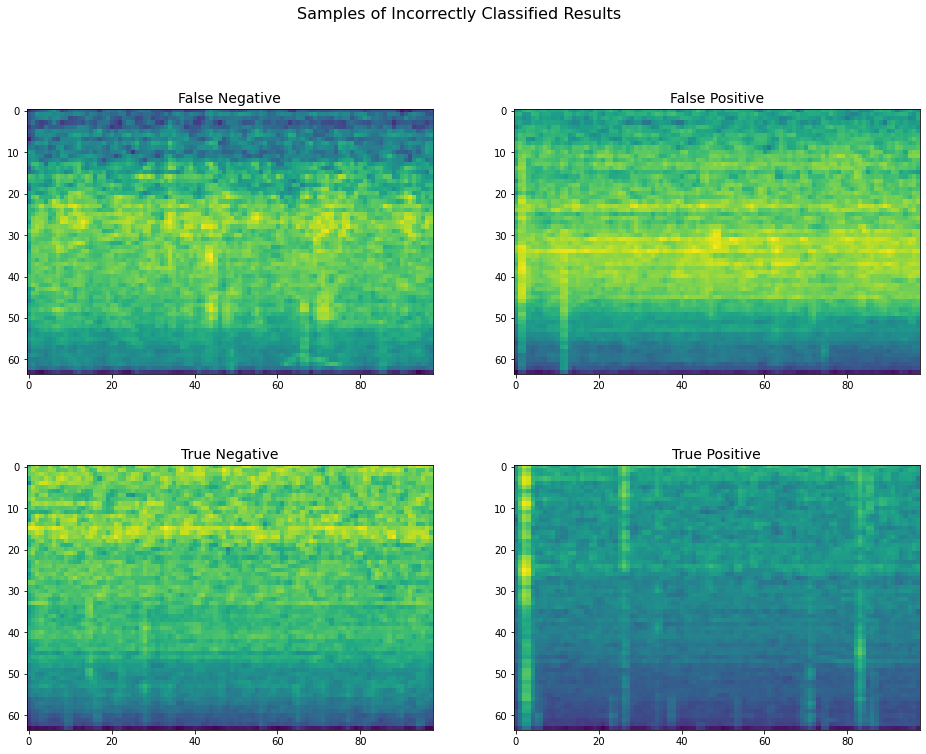

In [198]:
# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
ax = axs.ravel()

af1 = test_dataset.windows[21][3]
af2 = test_dataset.windows[3318][3]
af3 = test_dataset.windows[1032][3]
af4 = test_dataset.windows[988][3]
start_idx = int(0 * params.SAMPLE_RATE) 
end_idx = int(2.5 * params.SAMPLE_RATE)

ax[0].imshow(af1.get_window(start_idx, end_idx).T)
ax[0].set_title('False Negative', fontsize=14)
ax[1].imshow(af2.get_window(start_idx, end_idx).T)
ax[1].set_title('False Positive', fontsize=14)
ax[2].imshow(af3.get_window(start_idx, end_idx).T)
ax[2].set_title('True Negative', fontsize=14)
ax[3].imshow(af4.get_window(start_idx, end_idx).T)
ax[3].set_title('True Positive', fontsize=14)
plt.suptitle("Samples of Incorrectly Classified Results", fontsize=16);

## 5. Conclusion and Recommendations
From the spectrogram, we can see that it is very difficult to determine which is true positive and true negative with the human eye alone. However, we can still arrive at certain intuitions. False negative may be caused by a noisy environment that dilutes the sound of the killer whale. For the false positive, we can observe bright streaks that may have been confused with actual streaks. Nonetheless, it is difficult to tell since other samples are very similar to these photos as well.

To improve the model, we will need to go further back than the modeling and look at the preprocessing steps that created these spectrograms. We would need to consider if the parameters used to clean the audio and to visualize is sufficient. Further knowledge of ocean sounds may be needed to arrive at the optimal data preparation steps.

In addition to improving the preprocessing steps, the model itself can still be improved. We can clearly see the precision-recall tradeoff in the results of our best model wherein class 1 had a high precision but very low recall. Precision was the main metric used in this project to make it comparable to the humpback whale study that reported a precision score of 0.97. However, having a low recall is also not desired since this lessens the already limited dolphin sound data that we have.

The project was limited to exploring only four architectures. Additional architectures can be explored to see if there are other models that can improve performance. In addition, transfer learning from the humpback whale studies can be attempted to see if using data trained on another cetaceans will help detect killer whale sounds. 

Lastly, this project made use of images to classify sounds. However, the audio data can also be converted into waves that can be processed via time series analysis. This approach may open doors to different insights based on the pattern of the audio and not just the frequency as captured by the spectrogram. All these potential information can unlock a whole new world underwater that we may never have known before. 

### References
- https://github.com/orcasound/orcadata/wiki
- https://www.mbari.org/at-sea/cabled-observatory/mars-science-experiments/mars-hydrophone-data/
- http://www.mwwphilippines.org/downloads/rm-marinemammals.pdf
- https://towardsdatascience.com/a-loss-function-suitable-for-class-imbalanced-data-focal-loss-af1702d75d75
- https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/